In [80]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [81]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [82]:
key = os.environ.get('AZURE_SEARCH_KEY', '347e549ffbc04054abf4196af5b51d83')

In [83]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [84]:
results = search_images_bing(key, 'One Piece')
ims = results.attrgot('contentUrl')
len(ims)

150

In [85]:
dest = 'gdrive/MyDrive/ai/images/OP.jpg'
download_url(ims[0], dest)

Path('gdrive/MyDrive/ai/images/OP.jpg')

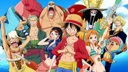

In [86]:
im = Image.open(dest)
im.to_thumb(128,128)

In [87]:
OP_characters = 'luffy', 'zoro', 'don krieg', 'buggy'
path = Path('OP characters')

In [88]:
if not path.exists():
    path.mkdir()
    for o in OP_characters:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} One Piece characters')
        download_images(dest, urls=results.attrgot('contentUrl'))

### Analyze
What do you think the above cell does?
* It basically is a failsafe for if the path.exist is false.


In [89]:
fns = get_image_files(path)
fns

(#573) [Path('OP characters/buggy/ca9362b5-00a8-4808-8c57-8ab1103330af.jpg'),Path('OP characters/buggy/a53b9087-f796-4612-85e3-d304c71589ef.jpg'),Path('OP characters/buggy/1e6e6408-8856-4c6d-b714-d958a0658da6.png'),Path('OP characters/buggy/2a08126a-4952-484a-83b8-9c38453733f3.jpg'),Path('OP characters/buggy/658aa9eb-5019-4415-865d-00dfb4cb122d.jpg'),Path('OP characters/buggy/e4f7e12b-8362-4e72-9222-a054cba17df7.jpg'),Path('OP characters/buggy/dbef0833-9a85-4aa6-8341-c9e67228b12d.jpg'),Path('OP characters/buggy/9ece6f60-1910-450b-a1cd-d451b086405f.jpg'),Path('OP characters/buggy/e6a17ebd-5ca7-4d7f-a42b-e84f7e183b10.gif'),Path('OP characters/buggy/7b83113d-6ba6-4181-8b0c-82a60385c365.jpg')...]

In [90]:
failed = verify_images(fns)
failed

(#53) [Path('OP characters/buggy/658aa9eb-5019-4415-865d-00dfb4cb122d.jpg'),Path('OP characters/buggy/bab59262-70e5-48cd-91b7-591643566645.png'),Path('OP characters/buggy/a715701a-54e2-49db-842c-f76e538b3510.jpg'),Path('OP characters/buggy/64c677d6-33cc-45ba-82ec-7cd6c3987160.png'),Path('OP characters/buggy/dc89d04e-b172-43c2-a81c-616bd92602fc.jpg'),Path('OP characters/buggy/5200968d-e129-449c-a557-7a36711ccd94.png'),Path('OP characters/buggy/99a12806-e941-4042-8e6e-9c374e86373f.jpg'),Path('OP characters/buggy/b56cf7f2-7103-4121-ae4a-07558d9e0c9a.jpg'),Path('OP characters/buggy/570dd14a-68e9-4c83-85fa-659dff2cb2f9.jpg'),Path('OP characters/buggy/14b6119b-cbd6-449c-b907-6291723afb68.png')...]

### Analyze
What do you think the above cell does?
* If the image fails, then you verify it. 



In [91]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [92]:
OP_characters = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [94]:
dls = OP_characters.dataloaders(path)

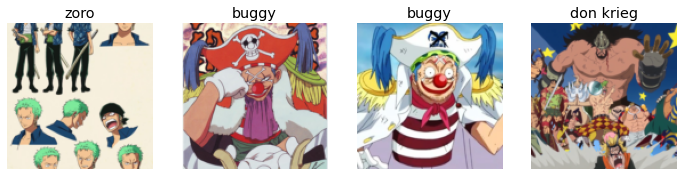

In [95]:
dls.valid.show_batch(max_n=4, nrows=1)

## Resize
* Notice the `item_tfms=Resize(128)`
* This tells our code to resize images to be 128by128 pixels
* Usually, machine learning needs all images to be the same size. Why do you think this might be? (Hint: think about what a neural network is and does)
  * It makes them standard so that the AI doesn't learn the wrong things. 
* The default for resize is to crop the image
* What might be less than great about cropping the image?
  * We lose details which means that the image might not be correct. 

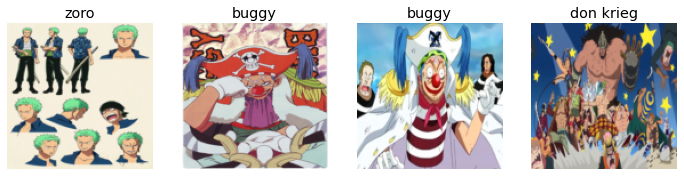

In [96]:
OP_characters = OP_characters.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = OP_characters.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### Analyze
* What did this version of resize do?
  * It zoomed it in on the bear, and made it streched.
* Do you think this is better or worse than cropping? Why?
  * I think it is better since it doesn't cut out any of the data.
* What might be less than great about this approach?
  * It might make the image blurry which might cause image detection to not work. 

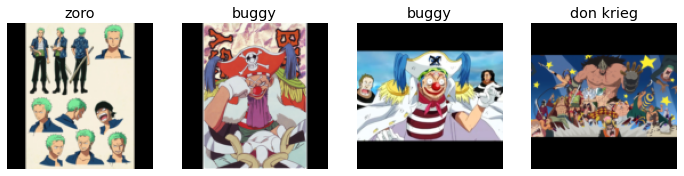

In [97]:
OP_characters = OP_characters.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = OP_characters.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### Analyze
* What did this version of resize do?
  * Adds black bars to image until its square
* Do you think this is better or worse than cropping? Why?
  * Better because we keep all the image data nice and sound
* What might be less than great about this approach?
  * We might be dealing with lower resolution than we could


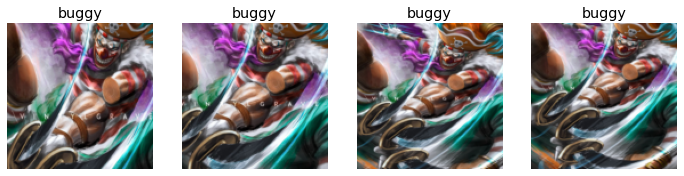

In [98]:
OP_characters = OP_characters.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = OP_characters.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Analyze
* This approach makes the objects of interest in different places in the image and at different sizes. Why might this be helpful for making a smarter neural network?
  * It would allow it to identify parts rather than 1 image, harder data, smarter AI. 


### Data Augmentation
* One trick of machine learning is **data augmentation**
* In this approach we effectively get a bigger set of training data by including not just the original image, but variations of it
* Observe the result of the below cell to see some of the standard augmentation approaches for computer vision

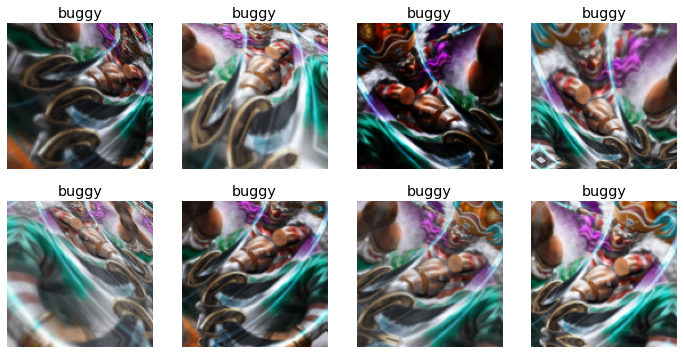

In [99]:
OP_characters = OP_characters.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = OP_characters.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [100]:
OP_characters = OP_characters.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = OP_characters.dataloaders(path)

In [101]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


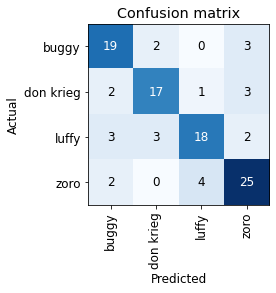

In [102]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Results
* The below cell will show the top 5 images the model is most confused about
* Do you notice anything interesting?
  * It catagorized the black bear as a grizzlybecause it has some brown patches. 

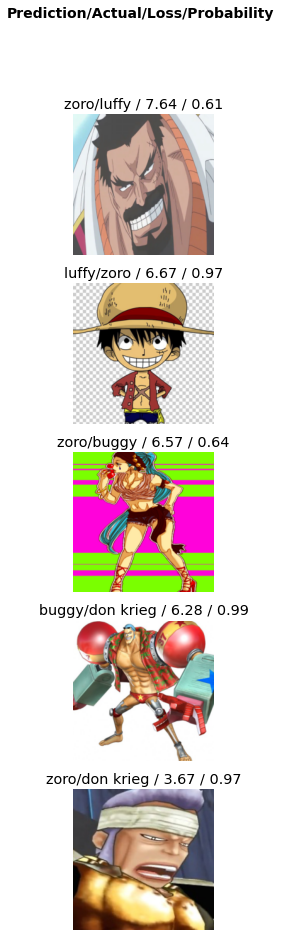

In [103]:
interp.plot_top_losses(5, nrows=5)

## Cleaning data
* A *huge* part of practical AI/ML/DS is doing things to make your data more usable, a process we call **cleaning** the data
* Especially when you get your data from the internet, it's quite likely that we'll end up with images that are labeled incorrectly
* One approach is to try to look through all the images, but that's boring and annoying
* A cleverer approach is to train a model and look at what confuses it
* Bad data is likely to confuse the model, so this is a decent way to find what stinks
* NOTE: not all things that confuse the model are bad data
* (By bad data, I'm talking about an image of a grizzly bear that's labeled as a black bear or an image of both types of bear at the same time, etc.)
* Running the below cell will generate an interactive widget to help identify and deal with bad data
* The widget does NOT remove data in and of itself. You need to use the next cell below for that
* The widget splits things into train (what we use to teach the model) and validation (what we're using to *evaluate* the model). It also splits things by the labels of the image (recall labels == "right answers")
* For each category, the images are sorted by how confused they make the model
* Use the next 2 cells and the widget to remove bad data
* Retrain the model without the bad data
* Did performance improve:
  * TODO

In [104]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:

for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# uncomment the above line and run the cell to delete bad data
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
# uncomment the above line and run the cell to move mislabeled data

# Your turn!

* Make sure you SAVE the notebook!!!
* Once you've done that, try adapting this notebook to make an image classifier for your own categories
* Some ideas:
  - apple varieties
  - make/model of car? (Only do a few)
  - plant/tree types?
  - spider type?
  - insect type?
  - komondor (a type of dog) vs mop

* Save your notebook frequently as you go!
